In [1]:
from matplotlib import pyplot as plt
from functions import *
%matplotlib inline
import tensorflow as tf

In [2]:
import glob
import numpy as np
from PIL import Image
import re
images = glob.glob('training/images/*')
gt_images = glob.glob('training/groundtruth/*')
test_images = glob.glob('test_set_images/*')
test_images = sorted_alphanumeric(test_images)

split = 0.9

In [3]:
print(len(images))
print(len(gt_images))
print(len(test_images))

100
100
50


In [5]:
np_imgs = to_numpy(images, 400, 400)
np_imgs.shape

(100, 400, 400, 3)

In [6]:
np_gt_imgs = to_numpy(gt_images, 400, 400)
np_gt_imgs = np.reshape(np_gt_imgs, (len(np_gt_imgs), 400, 400, 1))
np_gt_imgs.shape

(100, 400, 400, 1)

In [7]:
np_test_imgs = to_numpy(test_images, 304, 304)
np_test_imgs.shape

(200, 304, 304, 3)

In [9]:
def get_random_train(imgs, gt, crop_width, crop_height):
    x = []
    y = []
    width = imgs[0].shape[1]
    height = imgs[0].shape[0]
    range_w = width - crop_width
    range_h = height - crop_height
    for i in range(len(imgs)):
        start_w = np.random.randint(0, range_w + 1)
        start_h = np.random.randint(0, range_h + 1)
        x.append(imgs[i][start_w:start_w+crop_width, start_h:start_h+crop_height, :])
        y.append(gt[i][start_w:start_w+crop_width, start_h:start_h+crop_height, :])
    return np.asarray(x), np.asarray(y)

In [10]:
crop_np_imgs, crop_np_gt_imgs = get_random_train(np_imgs, np_gt_imgs, 304, 304)

In [11]:
crop_np_imgs.shape

(100, 304, 304, 3)

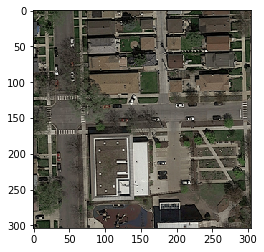

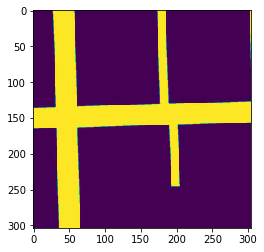

In [12]:
plt.imshow(crop_np_imgs[1], interpolation='nearest')
plt.show()
plt.imshow(crop_np_gt_imgs[1], interpolation='nearest')
plt.show()

In [14]:
X_train, X_test, y_train, y_test = split_data(crop_np_imgs, crop_np_gt_imgs, split)

In [15]:
X_train, X_test, y_train, y_test = X_train/255, X_test/255, y_train/255, y_test/255

In [16]:
input_shape = (len(X_train), 304, 304, 3)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid'))
model.add(tf.keras.layers.Conv2D(32, 3, activation='relu', padding="same"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid'))
model.add(tf.keras.layers.Conv2D(32, 3, activation='relu', padding="same"))
model.add(tf.keras.layers.UpSampling2D(size=(2, 2)))
model.add(tf.keras.layers.Conv2D(32, 3, activation='relu', padding="same"))
model.add(tf.keras.layers.UpSampling2D(size=(2, 2)))
model.add(tf.keras.layers.Conv2D(1, 3, activation='relu', padding="same"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 304, 304, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 152, 152, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 152, 152, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 76, 76, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 76, 76, 32)        9248      
                                                                 
 up_sampling2d (UpSampling2D  (None, 152, 152, 32)     0

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=dice_coef_loss,#tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()])

model.fit(X_train, y_train, epochs=5)
model.evaluate(X_test, y_test)

Epoch 1/5
3/3 [==============================] - 11s 3s/step - loss: 0.0867 - binary_accuracy: 0.7791 - false_negatives: 1837328.0000
Epoch 2/5
3/3 [==============================] - 11s 3s/step - loss: 0.0816 - binary_accuracy: 0.7791 - false_negatives: 1837328.0000
Epoch 3/5
3/3 [==============================] - 11s 3s/step - loss: 0.0810 - binary_accuracy: 0.7791 - false_negatives: 1837328.0000
Epoch 4/5
3/3 [==============================] - 11s 3s/step - loss: 0.0804 - binary_accuracy: 0.7791 - false_negatives: 1837328.0000
Epoch 5/5
1/1 [==============================] - 0s 293ms/step - loss: 0.0758 - binary_accuracy: 0.7928 - false_negatives: 191441.0000


[0.07579304277896881, 0.7928486466407776, 191441.0]

In [19]:
test = model.predict(X_test)

In [20]:
tr = model.predict(X_train)

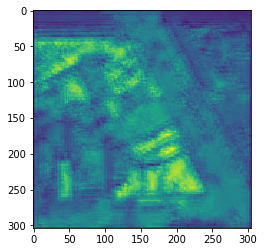

In [21]:
plt.imshow(tr[7], interpolation='nearest')
plt.show()

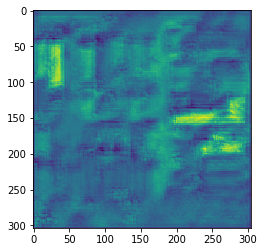

In [22]:
plt.imshow(test[3], interpolation='nearest')
plt.show()

In [23]:
pr = model.predict(np_test_imgs)

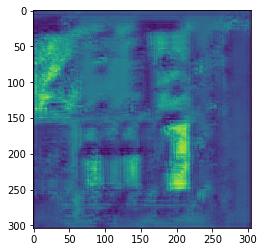

In [24]:
plt.imshow(pr[8], interpolation='nearest')
plt.show()

In [25]:
pr[0][0:0+16,0:0+16,:].sum()/65280 #/65280

0.05172576156317019

In [26]:
sized_pr = []
for i in range(int(len(pr)/4)):
    a = np.concatenate((pr[i],pr[i+1]),axis=1)
    b = np.concatenate((pr[i+2],pr[i+3]),axis=1)
    sized_pr.append(np.concatenate((a,b),axis=0))
sized_pr = np.asarray(sized_pr)
sized_pr.shape

(50, 608, 608, 1)

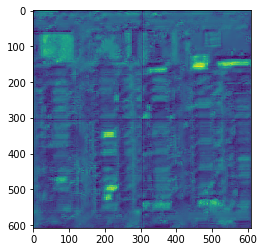

In [27]:
plt.imshow(sized_pr[0], interpolation='nearest')
plt.show()

In [28]:
sized_pr[0].sum() 

5200149.0

In [29]:
#avg, we could do double threshhold
def outputx16(nump, treshhold):
    pred = []
    for w in range(0,nump.shape[1],16):
        for h in range(0,nump.shape[0],16):
            if nump[w:w+16,h:h+16,:].sum()/65280 > treshhold:
                pred.append(1)
            else:
                pred.append(0)
    return np.asarray(pred)

In [30]:
pred_first = outputx16(sized_pr[0],0.065)
print(pred_first.shape)
pred_first = np.reshape(pred_first, (38, 38))
print(pred_first.shape)

(1444,)
(38, 38)


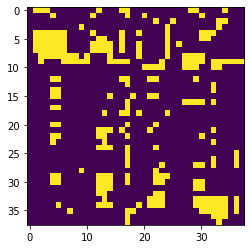

In [31]:
plt.imshow(pred_first, interpolation='nearest')
plt.show()